<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/BOW_LR_TwitterDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import torch
import pandas as pd
import re
import os
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import kagglehub

In [ ]:
# Define dataset directory
dataset_dir = "/root/.cache/kagglehub/datasets/sudishbasnet/truthseekertwitterdataset2023/"

# Recursively find the dataset file
file_name = None
for root, dirs, files in os.walk(dataset_dir):
    for f in files:
        if "Truth_Seeker_Model_Dataset" in f and f.endswith(".csv"):
            file_name = os.path.join(root, f)
            break
    if file_name:
        break

# Raise an error if the file is not found
if not file_name:
    raise FileNotFoundError("Dataset file not found in the directory or its subdirectories.")

# Load the dataset
df = pd.read_csv(file_name)
print("Dataset preview:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

# Check and handle missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)
df.dropna(subset=['tweet', 'BinaryNumTarget'], inplace=True)

# Rename columns for consistency
df.rename(columns={'statement': 'text', 'BinaryNumTarget': 'label'}, inplace=True)

# Filter the data to include only texts with length < 50 and remove duplicates
filtered_texts = []
filtered_labels = []
for text, label in zip(df['text'], df['label']):
    if len(text) > 50 and text not in filtered_texts:
        filtered_texts.append(text)
        filtered_labels.append(label)

# Create a new filtered DataFrame
filtered_df = pd.DataFrame({'text': filtered_texts, 'label': filtered_labels})


Dataset preview:
   Unnamed: 0      author                                          statement  \
0           0  D.L. Davis  End of eviction moratorium means millions of A...   
1           1  D.L. Davis  End of eviction moratorium means millions of A...   
2           2  D.L. Davis  End of eviction moratorium means millions of A...   
3           3  D.L. Davis  End of eviction moratorium means millions of A...   
4           4  D.L. Davis  End of eviction moratorium means millions of A...   

   target  BinaryNumTarget                 manual_keywords  \
0    True              1.0  Americans, eviction moratorium   
1    True              1.0  Americans, eviction moratorium   
2    True              1.0  Americans, eviction moratorium   
3    True              1.0  Americans, eviction moratorium   
4    True              1.0  Americans, eviction moratorium   

                                               tweet 5_label_majority_answer  \
0  @POTUS Biden Blunders - 6 Month Update\n\nInfl

In [ ]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply text preprocessing
filtered_df['processed_text'] = filtered_df['text'].apply(preprocess_text)

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    filtered_df['processed_text'], filtered_df['label'], test_size=0.2, random_state=42
)


Model Accuracy: 0.79
Unique classes in test labels: [0.0, 1.0]

Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.56      0.69        79
        True       0.76      0.96      0.84       113

    accuracy                           0.79       192
   macro avg       0.83      0.76      0.77       192
weighted avg       0.81      0.79      0.78       192



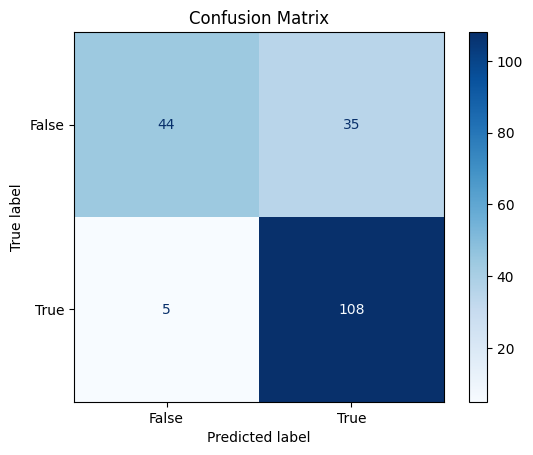


Sample Predictions:

Sample 1
Text: a photo shows women who gathered to scream at trump through their vaginas
Predicted: False, Actual: False

Sample 2
Text: says dan patrick has called immigration into texas an invasion and said immigrants coming into texas bring thirdworld diseases
Predicted: True, Actual: True

Sample 3
Text: if you want to vote in texas you can use a concealedweapon permit as a valid form of identification but a valid student id isnt good enough
Predicted: True, Actual: True

Sample 4
Text:  in 2013 obama determined social security would not send checks through the usps because it was not secure
Predicted: True, Actual: False

Sample 5
Text: the white house doctored a photo of a donald trump event to make the crowd look bigger
Predicted: True, Actual: False


In [ ]:
# Tfidf
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Model Training with Logistic Regression
model = LogisticRegression(max_iter=200, solver='saga', penalty='l2', C=1.0)
model.fit(X_train, train_labels)

# Predict on the test set
predictions = model.predict(X_test)

accuracy = accuracy_score(test_labels, predictions)
print(f"\nModel Accuracy: {accuracy:.2f}")

# Handle single-class cases for classification report and confusion matrix
unique_classes = sorted(test_labels.unique())
print("Unique classes in test labels:", unique_classes)

# Adjust target names dynamically based on unique classes
target_names = ['False', 'True'][:len(unique_classes)]

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, predictions, labels=unique_classes, target_names=target_names))

# Confusion Matrix
if len(unique_classes) > 1:  # Plot confusion matrix only if there are at least two classes
    conf_matrix = confusion_matrix(test_labels, predictions)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=target_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("\nConfusion Matrix not displayed due to single class in the test set.")

# Display a few predictions
print("\nSample Predictions:")
for i, (text, pred, true_label) in enumerate(zip(test_texts[:5], predictions[:5], test_labels[:5])):
    print(f"\nSample {i+1}")
    print(f"Text: {text}")
    print(f"Predicted: {'True' if pred else 'False'}, Actual: {'True' if true_label else 'False'}")